# KNN + KMeans
Aquest notebook està dissenyat per aplicar els algoritmes KNN i KMeans en la base de dades de _renda_ i _rent_price_.

L'objectiu del notebook és executar un KNN per tal de predir els districtes a partir de les tres bases de dades. Es fará un KNN ja que és el model de classificació més bàsic i podria ser suficient per aquest cas d'ús. Si s'observa que la predicció és bona, significa que les variables permeten representar informació d'aquests districtes i, per tant, es podria aplicar un model més complex per a plsamar la predicció.

A més a més, es farà un KMeans per tal de veure si els districtes es poden agrupar en clusters. Això podria ser útil per a la creació de variables en un futur model més complex. També es podria utilitzar per a fer un profiling i un estudi aprofundit d'aquests grups de districtes.

In [19]:
from pyspark.sql import SparkSession
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

In [20]:
#Inicia sessió a spark
spark = SparkSession.builder\
    .config("spark.jars", "duckdb.jar") \
    .getOrCreate()

In [21]:
# Llegim la base de dades
DF = spark.read \
  .format("jdbc") \
  .option("url", "jdbc:duckdb:../exploited_zone/freshdata_exploited1.db") \
  .option("driver", "org.duckdb.DuckDBDriver") \
  .option("query", "SELECT * FROM nova_base") \
  .load()
DF.show()

+----+-------------------+-------------------+-------------------+-------------------+
|Year|           District|   Year_Price_month|      Year_Price_m2|    District_Income|
+----+-------------------+-------------------+-------------------+-------------------+
|2015|     Horta-Guinardo|0.23929853325366826|0.36386151940989603|0.18996447967479674|
|2021|          Les_Corts| 0.5665535385146733| 0.5975901398086828| 0.4859704561403509|
|2016|     Sants-Montjuic| 0.2749316692108045| 0.4447362411509477| 0.1827870170940171|
|2015|     Sants-Montjuic|  0.247910301005466|0.38754598969830756| 0.1763603247863248|
|2019|     Sants-Montjuic|0.36016970316529145| 0.5404201872573647| 0.2292812393162393|
|2021|Sarria-Sant_Gervasi|  0.596762896080691| 0.6530077262693158| 0.6646924591836735|
|2020|          Les_Corts| 0.5927254369178394| 0.6444996320824136|0.47797108771929825|
|2016|         Nou_Barris|  0.204482600232365|0.32688251165072363| 0.1293284017094017|
|2020|        Sant_Andreu| 0.33025385111489

In [22]:
db=DF.toPandas()
db

,Year,District,Year_Price_month,Year_Price_m2,District_Income
0,2015,Horta-Guinardo,0.239299,0.363862,0.189964
1,2021,Les_Corts,0.566554,0.597590,0.485970
2,2016,Sants-Montjuic,0.274932,0.444736,0.182787
3,2015,Sants-Montjuic,0.247910,0.387546,0.176360
4,2019,Sants-Montjuic,0.360170,0.540420,0.229281
...,...,...,...,...,...
63,2020,Sarria-Sant_Gervasi,0.629140,0.669334,0.653608
64,2021,Horta-Guinardo,0.329165,0.486065,0.253500
65,2020,Ciutat_Vella,0.411760,0.647144,0.122834
66,2016,Eixample,0.402218,0.503702,0.302241


### KNN

In [23]:

# Divideix les dades en conjunts d'entrenament i prova
X = db[['Year_Price_month', 'Year_Price_m2', 'District_Income']]
y = db['District']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Entrena el model KNN
k = 5  # nombre de veïns
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

# Prediu en el conjunt de prova
y_pred = knn_model.predict(X_test)

# Avalua el rendiment del model
print("Precisió del model KNN:", accuracy_score(y_test, y_pred))
print("\nInforme de classificació:\n", classification_report(y_test, y_pred))



Precisió del model KNN: 0.5

Informe de classificació:
                      precision    recall  f1-score   support

       Ciutat_Vella       1.00      1.00      1.00         1
             Gracia       0.00      0.00      0.00         1
     Horta-Guinardo       0.33      0.50      0.40         2
          Les_Corts       0.50      1.00      0.67         1
         Nou_Barris       1.00      1.00      1.00         2
        Sant_Andreu       0.00      0.00      0.00         0
         Sant_Marti       0.33      1.00      0.50         1
     Sants-Montjuic       0.00      0.00      0.00         4
Sarria-Sant_Gervasi       1.00      0.50      0.67         2

           accuracy                           0.50        14
          macro avg       0.46      0.56      0.47        14
       weighted avg       0.46      0.50      0.45        14



/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users

### Clustering Kmeans

In [24]:
def trobar_numero_clusters(dades, max_clusters=10):
    # Emmagatzema valors d'inèrcia i silueta per a cada nombre de clusters
    inercia = []
    silhouette_scores = []
    
    # Prova diferents nombres de clusters
    for n_clusters in range(2, max_clusters + 1):
        # Inicialitza i ajusta el model KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(dades)
        
        # Calcula la inèrcia (suma de les distàncies quadrades de cada punt al centroid més proper)
        inercia.append(kmeans.inertia_)
        
        # Calcula el coeficient de la silueta
        if len(set(kmeans.labels_)) > 1:  # Assegura't que hi hagi almenys 2 clusters
            silhouette_scores.append(silhouette_score(dades, kmeans.labels_))
        else:
            silhouette_scores.append(np.nan)
    
    # Troba el colze en la corba d'inèrcia (mètode del colze)
    deltas = np.diff(inercia, 2)  # Segona derivada de la corba d'inèrcia
    clusters_optims = np.argmin(deltas) + 2  # El nombre de clusters on es produeix el colze
    
    return clusters_optims



In [25]:
# Selecciona les característiques rellevants per al clustering
X = db[['Year_Price_month', 'Year_Price_m2', 'District_Income']]

clusters_optims = trobar_numero_clusters(X)

# Aplica KMeans
kmeans = KMeans(n_clusters=clusters_optims, random_state=42)  # Canvia el nombre de clústers segons desitgis
kmeans.fit(X)

# Afegeix les etiquetes dels clústers al DataFrame original
db['Cluster'] = kmeans.labels_

# Visualitza els resultats

db

/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The defa

,Year,District,Year_Price_month,Year_Price_m2,District_Income,Cluster
0,2015,Horta-Guinardo,0.239299,0.363862,0.189964,6
1,2021,Les_Corts,0.566554,0.597590,0.485970,4
2,2016,Sants-Montjuic,0.274932,0.444736,0.182787,1
3,2015,Sants-Montjuic,0.247910,0.387546,0.176360,6
4,2019,Sants-Montjuic,0.360170,0.540420,0.229281,7
...,...,...,...,...,...,...
63,2020,Sarria-Sant_Gervasi,0.629140,0.669334,0.653608,0
64,2021,Horta-Guinardo,0.329165,0.486065,0.253500,5
65,2020,Ciutat_Vella,0.411760,0.647144,0.122834,3
66,2016,Eixample,0.402218,0.503702,0.302241,2


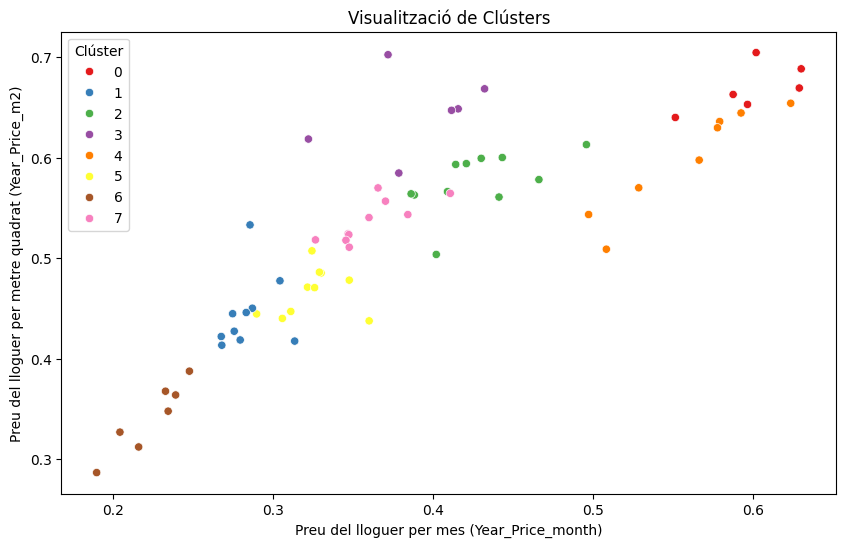

In [26]:
# Crea una figura y un eix
fig, ax = plt.subplots(figsize=(10, 6))

# Grafica els punts de dades agrupats per clústers
sns.scatterplot(x='Year_Price_month', y='Year_Price_m2', hue='Cluster', data=db, palette='Set1', ax=ax)

# Afegeix etiquetes i títol
plt.xlabel('Preu del lloguer per mes (Year_Price_month)')
plt.ylabel('Preu del lloguer per metre quadrat (Year_Price_m2)')
plt.title('Visualització de Clústers')

# Mostra la llegenda
plt.legend(title='Clúster')

# Mostra el gràfic
plt.show()


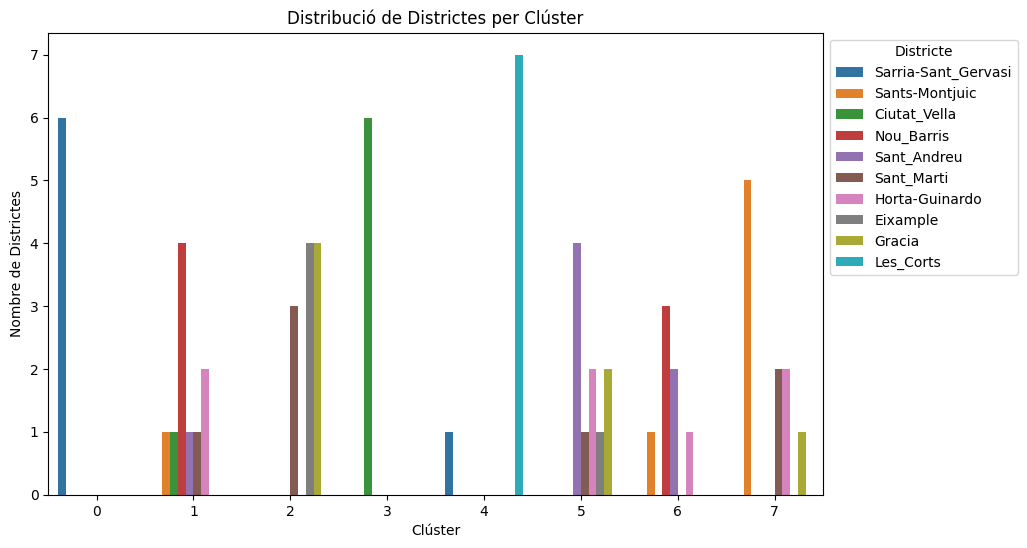

In [27]:
# Mostra un plot dels barris que apareixen i la seva freqüència per a cada clúster
plt.figure(figsize=(10, 6))
sns.countplot(data=db, x='Cluster', hue='District')
plt.title('Distribució de Districtes per Clúster')
plt.xlabel('Clúster')
plt.ylabel('Nombre de Districtes')
plt.legend(title='Districte', bbox_to_anchor=(1, 1))
plt.show()


El KNN s'utilitza per fer una predicció acurada dels districtes. En aquest cas, hem pogut concloure amb un 50% d'exactitud que no es tracta d'un model que predigui massa bé, però sí és cert que prediu cinc vegades millor que un model predictiu aleatori. Això pot ser degut a que tractem només amb set anys de dades, incloent l'any del COVID, fet que provoca un biaix que no permet veure amb claredat els patrons que segueixen els districtes.

En relació al KMeans, s'ha implementat per explorar si hi havia cap distribució interessant a les dades. Sembla que Eixample i Gràcia tenen certa relació, però l'anàlisi és limitat per la manca de dades suficients.

En resum, amb aquestes limitacions en les dades, el KNN i el KMeans proporcionen una idea inicial sobre els districtes i els patrons, però no permeten un anàlisi profund i definitiu.